# Microtask 3

## Aim

Produce a notebook with charts showing the distribution of time-to-close for issues already closed, and opened during the last year, for each of the repositories analyzed, and for all of them together. Use Pandas for this, and the Python charting library of your choice (as long as it is a FOSS module).

### Retrieving Data from OmegaUp

From the command line run Perceval on the github repositories to analyze, to produce a file with JSON documents for all its issues (the list obtained contains the pull request also), one per line (git-commits.json).


Syntax for using Perceval for Github
`perceval github owner repository [--sleep-for-rate] [-t XXXXX]`


Date of Retrieval: 1st March 2019
##### Example:

`$ perceval github --json-line -category pull_request omegaup omegaup --sleep-for-rate -t a247a6b7d506736da6d653cddc060a96bfbd9cb3 > data_source.json`

`$ perceval github --json-line -category issue omegaup omegaup --sleep-for-rate -t a247a6b7d506736da6d653cddc060a96bfbd9cb3 >> data_source.json`

Gets the information about Pull Request and Issues from Github

###### Current Problem With Perceval    
    The Existing Problem with Perceval is that when running the above command with category issue it also 
    fetches the pull request because the github api returns the pull request under issues. For Ex 
   ##### https://api.github.com/repos/omegaup/omegaup/issues/2378
    
    This is a pull request but in url you can see it is returned as issue
   
    So we have to remove the duplicates (done in __init__() function)
    
    

`$ perceval git --json-line https://github.com/omegaup/omegaup >> data_source.json`

    Gets the information about Commits from Github

----------------------------------------------------------------------------------------
--sleep-for-rate To avoid having perceval exiting when the rate limit is exceeded

-t is token for Github API

In [3]:
import json
import datetime
from dateutil import parser
import pandas as pd

import warnings ## to ignore warnings that come in importing pandas
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

## Summarize Function

#### @arguments 

<b>line</b>: item to be summarized<br>

summary{
    repo,<br>
    hash,<br>
    author,<br>
    author_date,<br>
    ....<br>
}

In [2]:
def summarize(issue):
    repo = issue['origin']
    cdata = issue['data']
    summary = {
            'repo': repo,
            'uuid': issue['uuid'],
            'author': cdata['user']['login'],
            'created_date': datetime.datetime.strptime(cdata['created_at'],
                                           "%Y-%m-%dT%H:%M:%SZ"),
            'closed_date':datetime.datetime.strptime(cdata['closed_at'],
                                         "%Y-%m-%dT%H:%M:%SZ") if cdata['closed_at'] else None, 
            'comments': cdata['comments'],
            'labels': cdata['labels'],
            'url': cdata['html_url'],
            'state':cdata['state']
    }
    return summary

## Class Code_Changes

Takes path to the JSON file as input parameter

In [7]:
class Code_Changes:
    """"Class for Code_Changes for Git repositories.
    
    Objects are instantiated by specifying a file with the
    commits obtained by Perceval from a set of repositories.
    
    Contains list for Issues.
        
    :param path: Path to file with one Perceval JSON document per line
    """
    
    def __init__(self, path):
        
        self.changes = {'issue':[],'commit':[],'pull_request':[]}
        with open(path) as data_file:
            for data in data_file:
                line = json.loads(data)
                if ('pull_request' not in line['data']) and (line['category'] == 'issue'):
                       self.changes['issue'].append(summarize(line))
        self.code_dataframe = {
            'issue':pd.DataFrame.from_dict(self.changes['issue'])
        }

#### Functions Available
- total_count() : returns the total number of issues till date
- count(): returns number of issues created in Period Of Time
    ###### Parameters
    - Since
    - Until
            

## Example of the implementation

In [84]:
code = Code_Changes('data_source.json')

In [85]:
print("Total Number Of Issues:",len(code.changes['issue']))

Total Number Of Issues: 1484


## First Issue in The Repository

In [86]:
code.changes['issue'].sort(key = lambda x:x['created_date'].replace(tzinfo=None))  ##sorting the issues with date 
first_commit = code.changes['issue'][0]
first_issue_year = first_commit['created_date'].year

print("Year of first issue: ",first_issue_year)

Year of first issue:  2011


## Number of Issues Closed and Opened Last Year

Showing distrubution of issues opened and closed last year

In [75]:
current_year = datetime.datetime.now().year
since = datetime.datetime.now()
frame = code.code_dataframe['issue']
frame = frame[frame['created_date'].apply(lambda x:x.year) < current_year]
frame = frame[frame['created_date'].apply(lambda x:x.year) >= current_year - 1]

## frame contains the issues in the last year

In [93]:
total_issues = frame.shape[0]
closed_issues = frame[frame['state'] == 'closed'].shape[0]
open_issues = total_issues - closed_issues
print("Total Number of Issues in last year: ",total_issues)
print("Total Number of Closed Issues in last year: ",closed_issues)
print("Total Number of Open Issues in last year: ",open_issues)

Total Number of Issues in last year:  306
Total Number of Closed Issues in last year:  201
Total Number of Open Issues in last year:  105


## Number of Issues Open and Closed Per Month Last Year

In [179]:
frame['month'] = frame['created_date'].apply(lambda x:x.month)
months = []
for i in range(1,13):
     months.append(datetime.date(2008, i, 1).strftime('%B'))
## generate months for indexing
closed = frame[frame['state'] == 'closed']
closed = closed.groupby(['month']).count()
closed = closed['state'].tolist()
## closed contain number of issues closed per month 
open = frame[frame['state'] == 'open']
open = open.groupby(['month']).count()
open = open['state'].tolist()
## open contain number of issues opened per month 

## Plotting for The Above Calculated Metric 

Using pandas dataframe bar plot

months[] <br>
closed[] <br>
open[] <br>
this 3 list are required and taken from the above codeblock

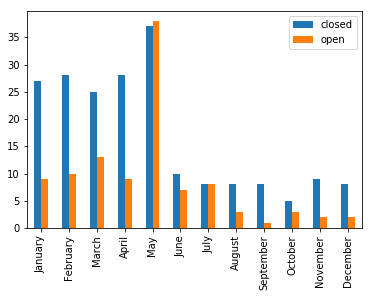

In [180]:
plot = pd.DataFrame({'closed':closed,'open':open},index=months)
plot.plot.bar(rot=90)

## Time-to-close for issues closed in last year

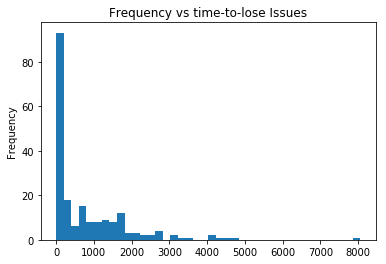

In [211]:
issue_frame = frame[frame['state']=='closed']
close_time=(issue_frame['closed_date']-issue_frame['created_date']).astype('timedelta64[h]')
        ## converted to number of hours taken by issue to close
max_time_to_close = close_time.max(axis=0)
close_time.plot.hist( bins=40,range=(0,max_time_to_close),x="asd",title='Frequency vs time-to-lose Issues')